### contract

begindate - дата начала  
enddate - дата окончания  
type - тип оплаты (раз в месяц, раз в год и тд)
paperlessbilling - выставление счета  
paymentmethod - способ оплаты  
monthlycharge - ежемесячная оплата  
totalcharges - обшая стоимость

### internet

internetservice - интернет сервис (предоставляемая услуга: DSL - модем(интернет через телефон), Fiber optic	- оптика)  
onlinesecurity - онлайн-безопасность  
onlinebackup - резервное копирование  
deviceprotection - защита устройства  
techsupport - техподдержка  
streamingtv - потоковое телевидение  
streamingmovies - потоковые фильмы

### personal

gender - пол  
seniorcitizen - пожилой человек (пенсионер)  
partner - партнер  
dependents - иждивенец (ребенок или тот за кого платит кто-то другой)

### phone

multiplelines - имеет несколько сим-карт / использует несколько предложений / несколько номеров

In [1]:
!pip install lifelines

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

In [3]:
contract = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

In [4]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contract.columns = contract.columns.str.lower()

In [7]:
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [8]:
contract['begindate'] = pd.to_datetime(contract['begindate'])

In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [10]:
contract['year_begin'] = contract['begindate'].dt.year
contract['month_begin'] = contract['begindate'].dt.month
contract['day_begin'] = contract['begindate'].dt.day
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,year_begin,month_begin,day_begin
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2017,4,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,1


<AxesSubplot:title={'center':'Количество новых пользователей за месяц в 2019 году'}, xlabel='month_begin'>

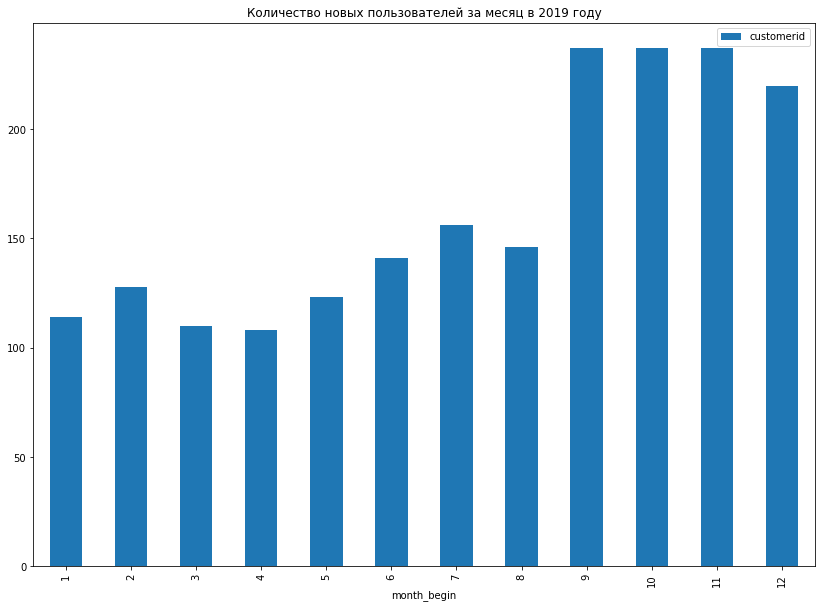

In [11]:
contract.query('year_begin == 2019').pivot_table(
    index='month_begin', values='customerid', aggfunc='count').plot.bar(
    figsize=(14, 10), title='Количество новых пользователей за месяц в 2019 году'
)

Повышение количества новых пользователей можно отметить во всем 2019 году, но особенно активно новые пользователи начали приходить с сентятбря по декабрь. Можно предположить, что повышение количества новых пользователей в 2019 году связано с пандемией и локдаунами. Люди чаще сидели дома и активнее пользовались интернетом. Если в 2018 году новые пользователи ежемесячно приходили в районе 80-100 человек, то в 2019 году этот показатель не опускался ниже 110 и в пике был больше 200. 

<AxesSubplot:title={'center':'Количество новых пользователей за месяц в 2018 году'}, xlabel='month_begin'>

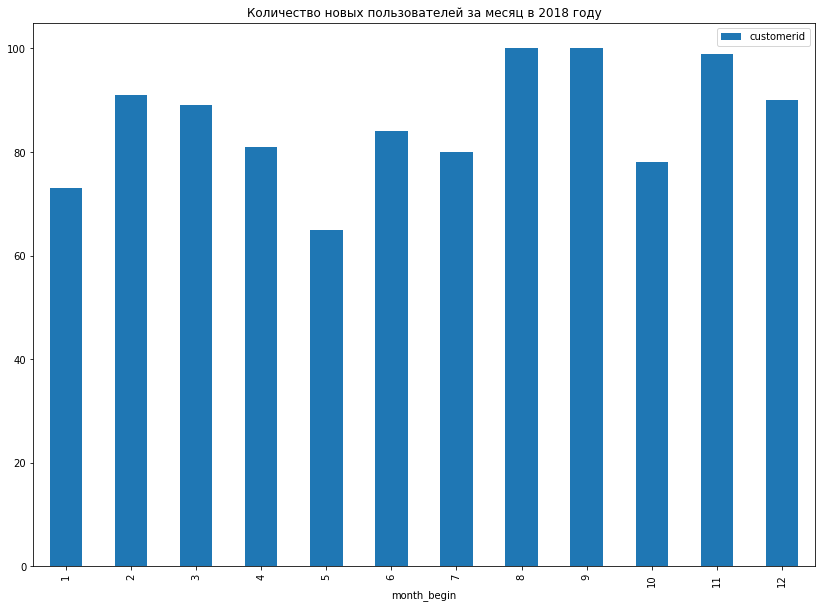

In [12]:
contract.query('year_begin == 2018').pivot_table(
    index='month_begin', values='customerid', aggfunc='count').plot.bar(
    figsize=(14, 10), title='Количество новых пользователей за месяц в 2018 году'
)

<AxesSubplot:title={'center':'Количество новых пользователей за год'}, xlabel='year_begin'>

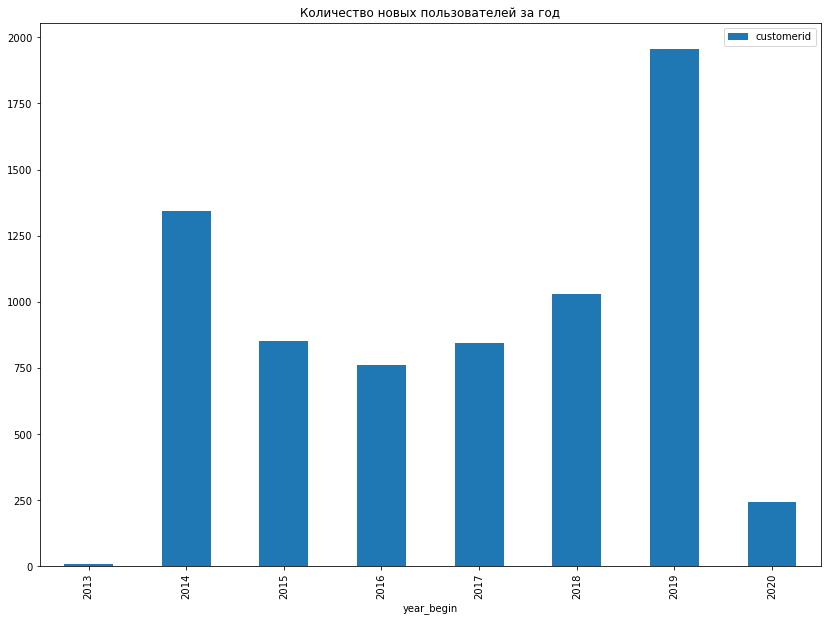

In [13]:
contract.pivot_table(
    index='year_begin', values='customerid', aggfunc='count').plot.bar(
    figsize=(14, 10), title='Количество новых пользователей за год'
)

Предположение: небольшой спад после 2014 года. Интернет услуги к 2014 году активно развивались и к тому моменту бОльшинство заинтересованных в интернете людей уже подключили себе необходимые услуги, дальше уже приходили люди у которых изначально повышенного интереса или потребности в интернете не было, они начали узнавать о возможностях интернета и постепенно подключали его. Отсюда спад и меньшее количество новых пользователей после 2014 года и до 2019. Если мое предположение с пандемией верно, то в 2019 году внешние факторы послужили тому, чтобы люди активнее обратили внимание на наличие у них интернета (банально были вынуждены подключить, чтобы работать удаленно), количество пользователей снова выросло.  

Это все предположения и если посмотреть по месяцам, то версия с пандемией не совсем подтверждается, потому что она началась в России в марте 2019 года, а активный рост в этом году приходится на сентябрь-декабрь, возможно имеет место быть вторая волна, которая как раз пришлась на конец лета-осень и люди после первой волны осознали необходимость интернета. Но опять же это только предположение

In [14]:
contract.query('year_begin == 2013').month_begin.unique()

array([11, 10, 12], dtype=int64)

In [15]:
contract.query('year_begin == 2020').month_begin.unique()

array([1, 2], dtype=int64)

Не учитываем 2013 и 2020 год, потому что в эти года данные только за 2 и 3 месяца

In [17]:
dict = []

for i in range(2014, 2020):
    
    count = len(contract[(contract['year_begin'] == i) & (contract['enddate'] == 'No')])
    dict.append(count)

In [18]:
dict

[1246, 729, 618, 646, 715, 976]

In [19]:
df = pd.DataFrame({'year' : list(range(2014, 2020)),
                   'count' : dict})
df

,year,count
0,2014,1246
1,2015,729
2,2016,618
3,2017,646
4,2018,715
5,2019,976


In [20]:
df = df.set_index('year')

In [21]:
df

,count
year,
2014,1246
2015,729
2016,618
2017,646
2018,715
2019,976


<AxesSubplot:title={'center':'Число фактических клиентов к концу года'}, xlabel='year'>

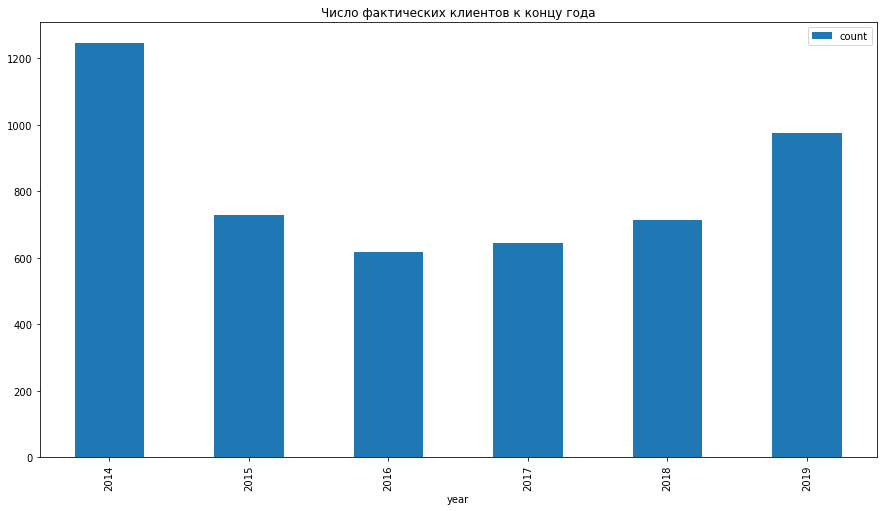

In [22]:
df.plot.bar(figsize=(15, 8), title='Число фактических клиентов к концу года')

верхний график описывает не фактическое количество клиентов, а количество оставшихся клиентов из пришедших
надо добавить в таблицу данные сколько человек в год приходит, сколько уходит и посчитать какой процент составляет
ежегодный отток клиентов и остаемся ли мы в плюсе по новым клиентам

In [24]:
# ставлю 0 тем, кто остался клиентом. 0 - клиент, 1 - ушел.

contract['end'] = contract['enddate'].apply(lambda x: 0 if x == 'No' else 1)

In [25]:
contract = contract.drop('day_begin', axis=1)

In [26]:
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,year_begin,month_begin,end
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2017,4,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,1


In [27]:
# замена No в колонке дат ухода клиентов на актуальную дату данных
# 2020-02-01

contract['enddate'] = contract['enddate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

In [28]:
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,year_begin,month_begin,end
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,2017,4,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,1


In [29]:
# посчитаю количество месяцев, которое клиент пользовался услугами, перед этим надо перевести тип данных в datetime64

contract['enddate'] = pd.to_datetime(contract['enddate'])

In [30]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
 8   year_begin        7043 non-null   int64         
 9   month_begin       7043 non-null   int64         
 10  end               7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 605.4+ KB


In [31]:
contract['count_days'] = (contract.enddate - contract.begindate).dt.days

In [32]:
contract['count_months'] = ((contract.enddate - contract.begindate)/np.timedelta64(1, 'M')).astype('int')

In [33]:
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,year_begin,month_begin,end,count_days,count_months
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,0,31,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,2017,4,0,1036,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,1,61,2
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,0,1371,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,1,61,2


In [34]:
contract['paperlessbilling'] = contract['paperlessbilling'].apply(lambda x: 1 if x == 'Yes' else 0)
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,year_begin,month_begin,end,count_days,count_months
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,2020,1,0,31,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.5,2017,4,0,1036,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,2019,10,1,61,2
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,2016,5,0,1371,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,2019,9,1,61,2


In [35]:
contract.paperlessbilling.unique()

array([1, 0], dtype=int64)

In [36]:
c_mm = contract.query('type == "Month-to-month" & 2013 < year_begin').drop('type', axis=1)
c_oy = contract.query('type == "One year" & 2013 < year_begin').drop('type', axis=1)
c_ty = contract.query('type == "Two year" & 2013 < year_begin').drop('type', axis=1)

In [37]:
print('Количество человек на месячной подписке:', c_mm.shape[0])
print('Количество человек на годовой подписке:', c_oy.shape[0])
print('Количество человек на двухгодовой подписке:', c_ty.shape[0])

Количество человек на месячной подписке: 3875
Количество человек на годовой подписке: 1472
Количество человек на двухгодовой подписке: 1688


##  Анализ выживаемости

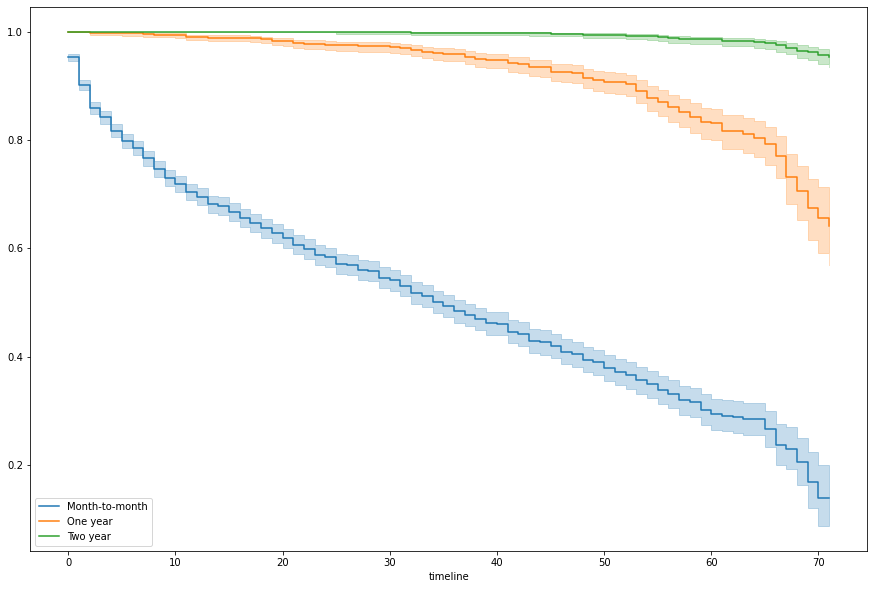

In [38]:
km = KaplanMeierFitter()

km.fit(c_mm['count_months'], c_mm['end'], label='Month-to-month')
ax = km.plot()

km.fit(c_oy['count_months'], c_oy['end'], label='One year')
ax1 = km.plot(ax=ax)

km.fit(c_ty['count_months'], c_ty['end'], label='Two year')
km.plot(ax=ax1, figsize=(15, 10));

График разделен на 3. Оплата помесячная, 1 раз в год, 1 раз в 2 года. Это сделано, потому что очевидно отток таких пользователей будет разным. У пользователей, которые оплачивают раз в месяц намного больше моментов для принятия решения продлевать/нет. Исходя из этого мы видим, что среди "ежемесячных" пользователей отток происходит сильнее. В первые месяцы видим резкий уход клиентов, т.е. много пользователей после использования услуги 1-2 месяца принимают решение уйти. Возможно это связано с какими-то пробными бесплатными подписками по истечению которых люди не продлевают на платной основе. Доверительный интервал увеличивается с продолжительностью, это также логично. Если бы мы увидели данные выходящие за него, то это было бы уже поводом срочно анализировать, что произошло и пользователи в большом количестве решили уйти. До определенного момента помесячный график можно назвать практически линейным, т.е. мы понимаем, что каждый месяц от нас уходило примерно одно и тоже количество пользователей, среднее значение можно принять за норму. Люди умирают, уходят в армию и другие ситуации на котрые мы не можем повлиять. С годовой и двухгодовой подпиской ситуация немного другая, там отток меньше и вероятно такими подписками пользуются люди, которые уже протестировали продукт на месячной подписке и перешли из соображений экономии на более длительные подписки. Т.е. такими подписками пользуются люди, которым нравится наш продукт и с их оттоком надо работат серьезнее, потому что просто так довольный клиент не уйдет. Также есть смысл предлагать людям на помесячной подписке которые уже продолжительное время пользуются нашими услугами предлагать переход на год или два. По графику видим что за почти 6 лет (5 лет и 8 месяцев) из тех клиентов, которые мы взяли изначально для анализа от нас ушло > 80% из помесячной подписки, ~ 40% из годовой подписки и
 < 10% из двух годовой <br />


<AxesSubplot:title={'center':'Среднее количество месяцев "жизни" клиента на разных подписках'}, xlabel='type'>

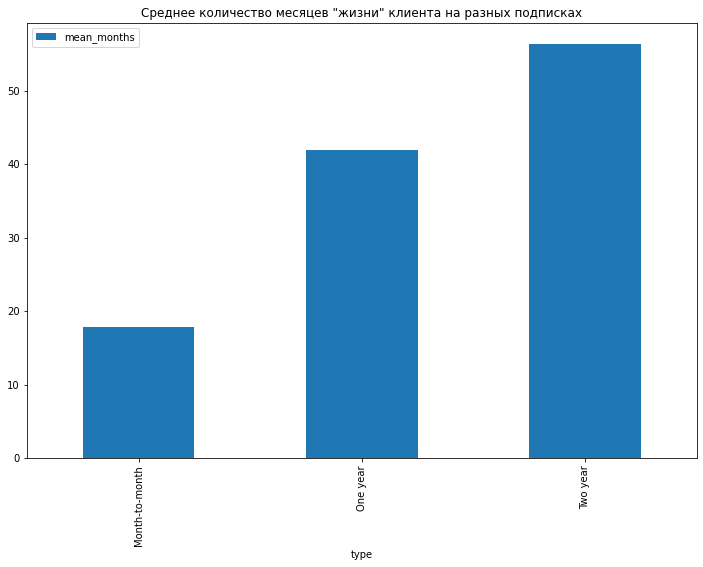

In [39]:
mean_count_manths = pd.DataFrame({'type' : ['Month-to-month', 'One year', 'Two year'],
                                  'mean_months' : [c_mm['count_months'].mean(), c_oy['count_months'].mean(), c_ty['count_months'].mean()]})

mean_count_manths = mean_count_manths.set_index('type')
mean_count_manths.plot.bar(figsize=(12, 8), title='Среднее количество месяцев "жизни" клиента на разных подписках')

In [40]:
mean_count_manths

,mean_months
type,
Month-to-month,17.833290
One year,41.889946
Two year,56.412322


In [41]:
contract.enddate.unique()

array(['2020-02-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

Для такого диапазона мало дат оттока клиентов. Возможно это связано с появлением конкурента.

In [42]:
contract.end.value_counts()

0    5174
1    1869
Name: end, dtype: int64

Дисбаланс классов

In [43]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [44]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [45]:
internet.columns = internet.columns.str.lower()

In [46]:
col = ['onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']

In [47]:
for i in list(col):
    internet[i] = internet[i].apply(lambda x: 0 if x == 'No' else 1)

In [48]:
#все "yes" = 1, "no" = 0
internet.head()

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


In [49]:
internet[col] = internet[col].astype('int64')

In [50]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   int64 
 3   onlinebackup      5517 non-null   int64 
 4   deviceprotection  5517 non-null   int64 
 5   techsupport       5517 non-null   int64 
 6   streamingtv       5517 non-null   int64 
 7   streamingmovies   5517 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 344.9+ KB


In [51]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [52]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [53]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Количество объектов совпадает с contract

In [54]:
personal.columns = personal.columns.str.lower()

In [55]:
personal.rename(columns={'gender': 'gender_m'}, inplace=True)

In [56]:
personal.head()

,customerid,gender_m,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [57]:
col_per = ['partner', 'dependents']

for i in list(col_per):
    personal[i] = personal[i].apply(lambda x: 0 if x == 'No' else 1)

In [58]:
personal['gender_m'] = personal['gender_m'].apply(lambda x: 0 if x == 'Female' else 1)

In [59]:
personal.head()

,customerid,gender_m,seniorcitizen,partner,dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0


In [60]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender_m       7043 non-null   int64 
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   int64 
 4   dependents     7043 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 275.2+ KB


In [61]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [62]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [63]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

тут тоже видим меньше объектов

In [64]:
phone.columns = phone.columns.str.lower()

In [65]:
phone.head()

,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [66]:
phone['multiplelines'] = phone['multiplelines'].apply(lambda x: 0 if x == 'No' else 1)
phone.head()

,customerid,multiplelines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


In [67]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


In [68]:
phone.multiplelines.value_counts()

0    3390
1    2971
Name: multiplelines, dtype: int64

# Объединение таблиц

In [69]:
df_1 = contract.merge(internet, on='customerid', how='left')

In [70]:
df_1 = df_1.merge(personal, on='customerid', how='left')

In [71]:
df_1 = df_1.merge(phone, on='customerid', how='left')

In [72]:
df_1.isna().sum()

customerid             0
begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
year_begin             0
month_begin            0
end                    0
count_days             0
count_months           0
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
gender_m               0
seniorcitizen          0
partner                0
dependents             0
multiplelines        682
dtype: int64

internetservice - сделать булевыми (1, 0), пропуски заполнить 0  
onlinesecurity - преобразовать тип данных в int, пропуски заполнить 0  
onlinebackup - преобразовать тип данных в int, пропуски заполнить 0  
deviceprotection - преобразовать тип данных в int, пропуски заполнить 0  
techsupport - преобразовать тип данных в int, пропуски заполнить 0  
streamingtv - преобразовать тип данных в int, пропуски заполнить 0  
streamingmovies - преобразовать тип данных в int, пропуски заполнить 0  
multiplelines - преобразовать тип данных в int, пропуски заполнить 0

In [73]:
df_1.internetservice.unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

In [74]:
# DSL - 1, Fiber optic - 0, NaN - 0

df_1['internetservice'] = df_1['internetservice'].apply(lambda x: 1 if x == 'DSL' else 0)

In [75]:
df_1 = df_1.fillna(0)

In [76]:
df_1.isna().sum()

customerid          0
begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
year_begin          0
month_begin         0
end                 0
count_days          0
count_months        0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
gender_m            0
seniorcitizen       0
partner             0
dependents          0
multiplelines       0
dtype: int64

In [77]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   int64         
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
 8   year_begin        7043 non-null   int64         
 9   month_begin       7043 non-null   int64         
 10  end               7043 non-null   int64         
 11  count_days        7043 non-null   int64         
 12  count_months      7043 non-null   int32         
 13  internetservice   7043 non-null   int64         
 14  onlinesecurity    7043 n

In [78]:
df_1[['onlinesecurity', 'onlinebackup', 'deviceprotection',
      'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']] = df_1[['onlinesecurity', 'onlinebackup', 'deviceprotection',
                                                                                 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']].astype('int64')

In [79]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   int64         
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
 8   year_begin        7043 non-null   int64         
 9   month_begin       7043 non-null   int64         
 10  end               7043 non-null   int64         
 11  count_days        7043 non-null   int64         
 12  count_months      7043 non-null   int32         
 13  internetservice   7043 non-null   int64         
 14  onlinesecurity    7043 n

In [80]:
df_1.totalcharges.value_counts()

20.2       11
           11
19.75       9
19.65       8
19.9        8
           ..
2896.55     1
1790.6      1
302.45      1
384.25      1
3834.4      1
Name: totalcharges, Length: 6531, dtype: int64

Нашлись объекты в totalcharges которые являются просто пробелом. Поскольку их всего 11шт, можно удалить без каких-либо последствий

In [81]:
df = df_1.query('totalcharges != " "')

In [82]:
len(df)

7032

In [83]:
df.totalcharges = df.totalcharges.astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   begindate         7032 non-null   datetime64[ns]
 2   enddate           7032 non-null   datetime64[ns]
 3   type              7032 non-null   object        
 4   paperlessbilling  7032 non-null   int64         
 5   paymentmethod     7032 non-null   object        
 6   monthlycharges    7032 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   year_begin        7032 non-null   int64         
 9   month_begin       7032 non-null   int64         
 10  end               7032 non-null   int64         
 11  count_days        7032 non-null   int64         
 12  count_months      7032 non-null   int32         
 13  internetservice   7032 non-null   int64         
 14  onlinesecurity    7032 n

C:\Users\ASUS-ADMIN\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# OHE и масштабирование

In [84]:
df2 = df.copy()

In [85]:
df2 = df2.drop('customerid', axis=1)

In [86]:
df2 = pd.get_dummies(df2, drop_first=True)
df2.head()

,begindate,enddate,paperlessbilling,monthlycharges,totalcharges,year_begin,month_begin,end,count_days,count_months,...,gender_m,seniorcitizen,partner,dependents,multiplelines,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,2020-01-01,2020-02-01,1,29.85,29.85,2020,1,0,31,1,...,0,0,1,0,0,0,0,0,1,0
1,2017-04-01,2020-02-01,0,56.95,1889.50,2017,4,0,1036,34,...,1,0,0,0,0,1,0,0,0,1
2,2019-10-01,2019-12-01,1,53.85,108.15,2019,10,1,61,2,...,1,0,0,0,0,0,0,0,0,1
3,2016-05-01,2020-02-01,0,42.30,1840.75,2016,5,0,1371,45,...,1,0,0,0,0,1,0,0,0,0
4,2019-09-01,2019-11-01,1,70.70,151.65,2019,9,1,61,2,...,0,0,0,0,0,0,0,0,1,0


Удалю признаки которые могут подсказать модели верное предсказание, такими являются все даты. Оставлю только количество месяцев, которое клиент провел с компанией. А также срежу данные по году и оставлю только 2014-2019, потому что 2013 и 2020 года не полные.

In [87]:
df2 = df2.query('2013 < year_begin < 2020')
len(df2)

6791

In [88]:
df2 = df2.drop(['begindate', 'enddate', 'year_begin', 'month_begin'], axis=1)


In [89]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6791 entries, 1 to 7042
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   paperlessbilling                       6791 non-null   int64  
 1   monthlycharges                         6791 non-null   float64
 2   totalcharges                           6791 non-null   float64
 3   end                                    6791 non-null   int64  
 4   count_days                             6791 non-null   int64  
 5   count_months                           6791 non-null   int32  
 6   internetservice                        6791 non-null   int64  
 7   onlinesecurity                         6791 non-null   int64  
 8   onlinebackup                           6791 non-null   int64  
 9   deviceprotection                       6791 non-null   int64  
 10  techsupport                            6791 non-null   int64  
 11  stre

In [90]:
df2.head()

,paperlessbilling,monthlycharges,totalcharges,end,count_days,count_months,internetservice,onlinesecurity,onlinebackup,deviceprotection,...,gender_m,seniorcitizen,partner,dependents,multiplelines,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
1,0,56.95,1889.50,0,1036,34,1,1,0,1,...,1,0,0,0,0,1,0,0,0,1
2,1,53.85,108.15,1,61,2,1,1,1,0,...,1,0,0,0,0,0,0,0,0,1
3,0,42.30,1840.75,0,1371,45,1,1,0,1,...,1,0,0,0,0,1,0,0,0,0
4,1,70.70,151.65,1,61,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,99.65,820.50,1,245,8,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


У меня появились сомнения, что тут нужна стандартизация

# Выделю ключевые признаки для обучения модели

In [91]:
cph = CoxPHFitter()

cph.fit(df2, 'count_months', event_col ='end')
cph.print_summary()

C:\Users\ASUS-ADMIN\anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:1601: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 6791 total observations, 4930 right-censored observations>
             duration col = 'count_months'
                event col = 'end'
      baseline estimation = breslow
   number of observations = 6791
number of events observed = 1861
   partial log-likelihood = -10506.16
         time fit was run = 2022-02-06 12:43:47 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
paperlessbilling                        0.25       1.28       0.06             0.13             0.36                 1.14                 1.43
monthlycharges                          0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
totalcharges                            0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
count_days                             -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
internetservice                         0.14       1.16       0.07             0.00             0.29                 1.00                 1.33
onlinesecurity                         -0.38       0.69       0.07            -0.51            -0.24                 0.60                 0.79
onlinebackup                           -0.18       0.84       0.06            -0.29            -0.06                 0.75                 0.94
deviceprotection                       -0.09       0.91       0.06            -0.21             0.02                 0.81                 1.02
techsupport                            -0.36       0.70       0.07            -0.50            -0.22                 0.61                 0.80
streamingtv                            -0.04       0.96       0.06            -0.16             0.08                 0.86                 1.09
streamingmovies                        -0.00       1.00       0.06            -0.12             0.12                 0.89                 1.12
gender_m                                0.01       1.01       0.05            -0.09             0.10                 0.92                 1.10
seniorcitizen                           0.12       1.13       0.06             0.01             0.23                 1.01                 1.26
partner                                -0.03       0.97       0.06            -0.14             0.08                 0.87                 1.08
dependents                             -0.10       0.91       0.07            -0.23             0.04                 0.79                 1.04
multiplelines                           0.01       1.01       0.06            -0.11             0.12                 0.90                 1.12
type_One year                          -0.64       0.53       0.09            -0.82            -0.46                 0.44                 0.63
type_Two year                          -0.98       0.37       0.14            -1.26            -0.70                 0.28                 0.49
paymentmethod_Credit card (automatic)  -0.07       0.93       0.09            -0.24             0.10                 0.78                 1.11
paymentmethod_Electronic check          0.22       1.24       0.07             0.08             0.36                 1.08                 1.43
paymentmethod_Mailed check             -0.03       0.97       0.09            -0.21             0.14                 0.81                 1.15

                                           z      p   -log2(p)
covariate                                                     
paperlessbilling                        4.33 <0.005      16.02
monthlycharges                          4.50 <0.005      17.17
totalcharges                            6.39 <0.005      32.52
count_days                

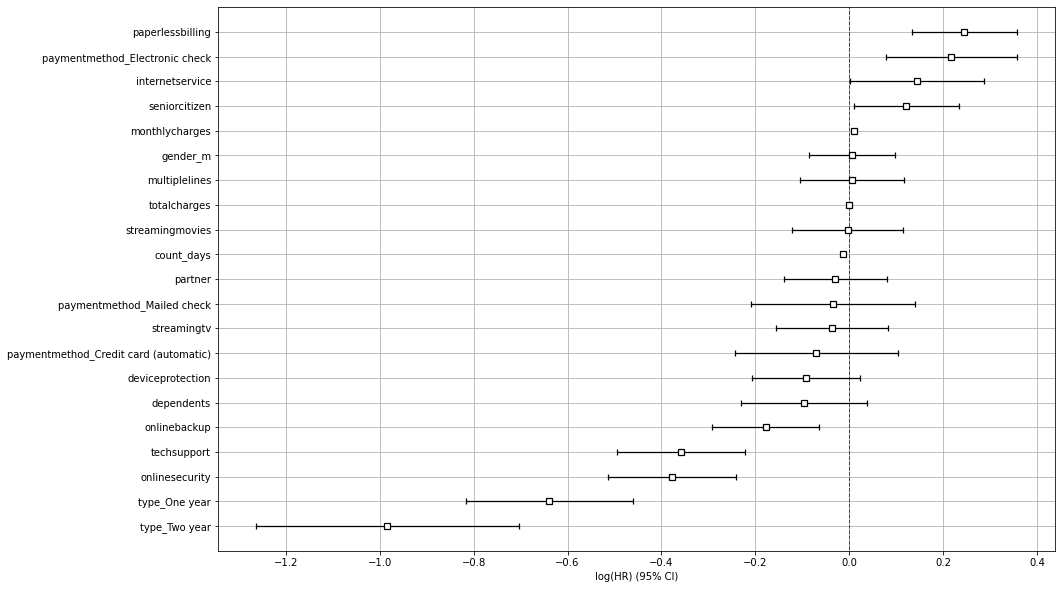

In [92]:
plt.figure(figsize=(15, 10))
plt.grid(True)
cph.plot();

<AxesSubplot:>

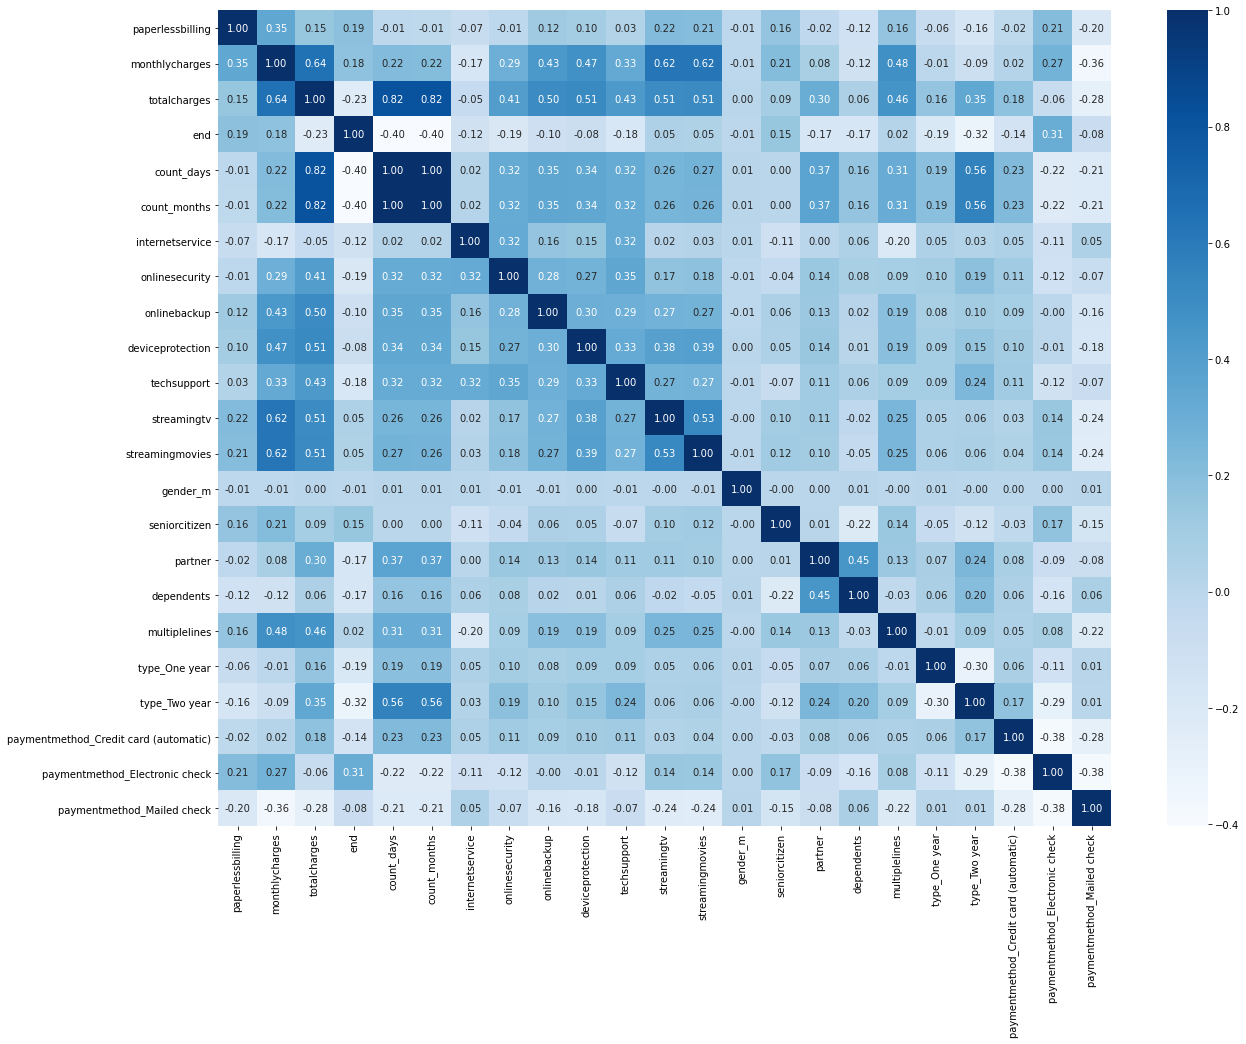

In [93]:
plt.figure(figsize=(20, 15))
sns.heatmap(df2.corr(), annot=True, cmap="Blues", fmt='.2f')

In [94]:
df2.shape

(6791, 23)

Избавлюсь от мультиколлинеарности

In [95]:
df2 = df2.drop(['monthlycharges', 'count_months'], axis = 1)


In [96]:
df2.shape

(6791, 21)

# Дисбаланс классов

In [98]:
df2.end.value_counts(normalize=True)

0    0.725961
1    0.274039
Name: end, dtype: float64

Надо домножить на 2.64, но нужно целое число, поэтому домножу на 3

In [99]:
features = df2.drop('end', axis=1)
target = df2['end']

print(features.shape)
print(target.shape)

(6791, 20)
(6791,)


In [100]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [101]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(5432, 20) (1359, 20) (5432,) (1359,)


In [102]:
lgbm_train_new = features_train.copy()
lgbm_test_new = features_test.copy()

lgbm_target_train_new = target_train.copy()
lgbm_target_test_new = target_test.copy()

In [103]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]

target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

repeat = 3
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

features_train, target_train = shuffle(features_upsampled, target_upsampled, random_state=12345)

<AxesSubplot:>

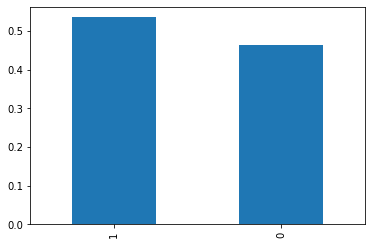

In [104]:
target_train.value_counts(normalize=True).plot.bar()

Теперь дисбаланс минимальный

# Подбор параметров для моделей

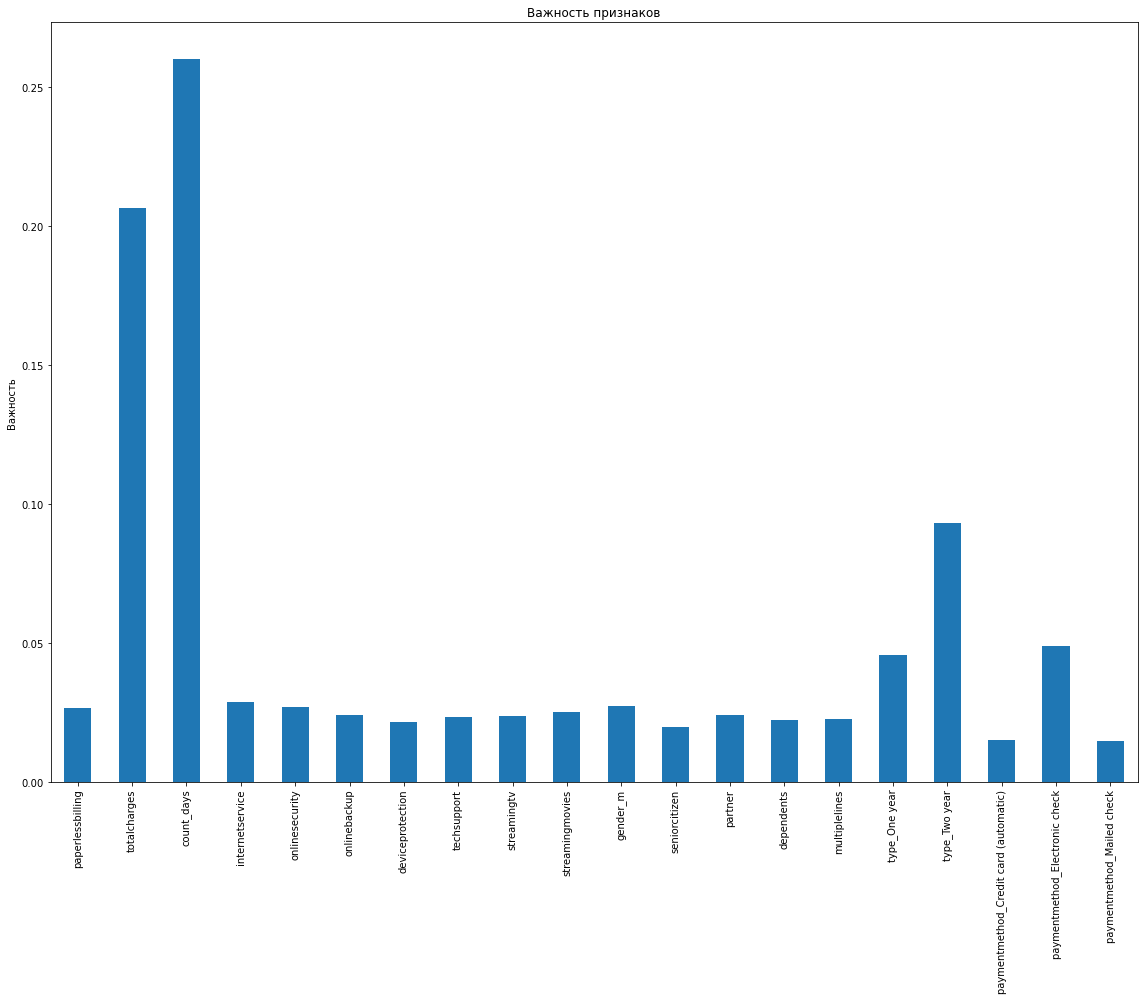

In [105]:
model_forest = RandomForestClassifier()
model_forest.fit(features_train, target_train)

imp = pd.Series(model_forest.feature_importances_, features_train.columns)

fig, ax = plt.subplots(figsize=(16,14))
imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Я попробовал убрать слабые признаки, но метрики либо остались такими же, либо при еще одном изменении признаков метрики падали

In [106]:
features_train.shape

(8448, 20)

In [107]:
features_train.columns

Index(['paperlessbilling', 'totalcharges', 'count_days', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'gender_m', 'seniorcitizen',
       'partner', 'dependents', 'multiplelines', 'type_One year',
       'type_Two year', 'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')

# RandomForestClassifier

In [108]:
model_rf = RandomForestClassifier(random_state=12345)

params_rf = {'max_depth' : [6, 10, 14, 16],
               'n_estimators' : [120, 200, 500, 800]}
grid_rf = GridSearchCV(model_rf, params_rf, scoring='roc_auc', cv = 5)
grid_rf.fit(features_train, target_train)

print('Лучшие параметры', grid_rf.best_params_)
print('ROC-AUC на тренировочной выборке:', grid_rf.best_score_)

Лучшие параметры {'max_depth': 16, 'n_estimators': 800}
ROC-AUC на тренировочной выборке: 0.9842772849673471


In [109]:
model = RandomForestClassifier(random_state=12345, max_depth=16, n_estimators=800)

model.fit(features_train, target_train)
predict_proba = model.predict_proba(features_test)
pred = model.predict(features_test)

print('ROC-AUC случайного леса на тестовой выборке:', roc_auc_score(target_test, predict_proba[:, 1]))
print('Accuracy на тестовой выборке:', accuracy_score(target_test, pred))
print('Точность (Precision):', precision_score(target_test, pred))
print('Полнота (Recall):', recall_score(target_test, pred))
print('F1:', f1_score(target_test, pred))

ROC-AUC случайного леса на тестовой выборке: 0.8807438654193818
Accuracy на тестовой выборке: 0.8278145695364238
Точность (Precision): 0.6586666666666666
Полнота (Recall): 0.6997167138810199
F1: 0.6785714285714285


In [110]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(15, 10))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

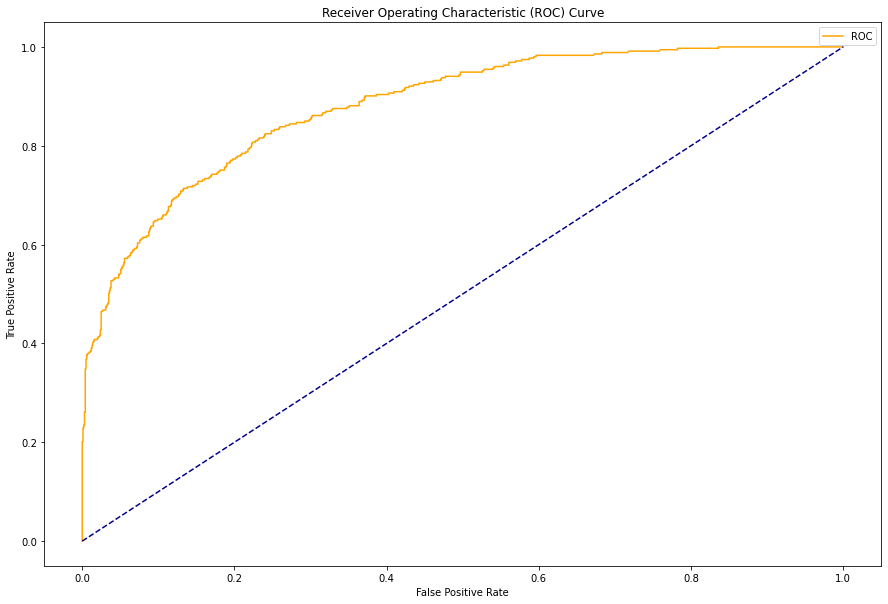

In [111]:
fpr, tpr, thresholds = roc_curve(target_test, predict_proba[:, 1])
plot_roc_curve(fpr, tpr)


# CatBoostClassifier

# LGBMClassifier

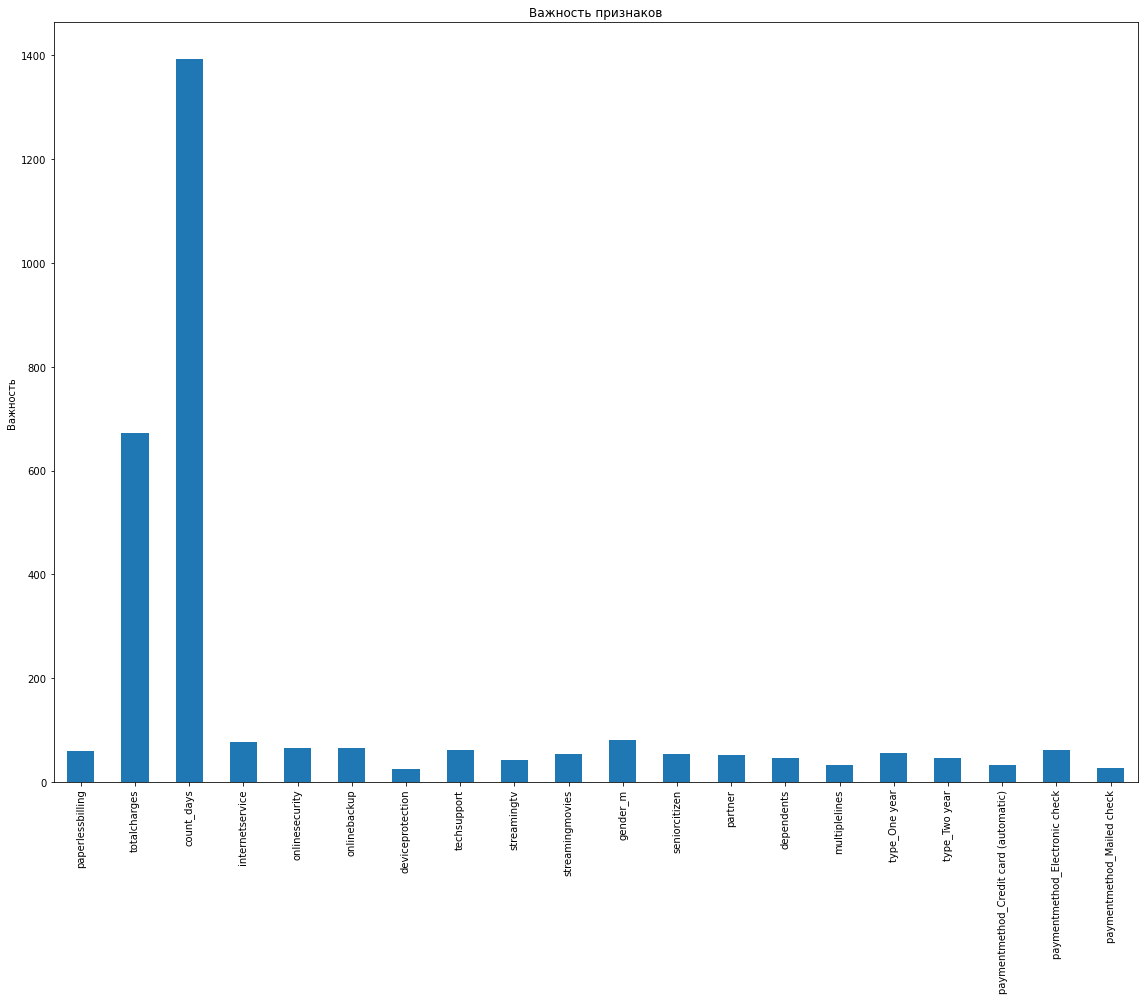

In [112]:
model_lgbm = LGBMClassifier(random_state=12345, objective="binary")
model_lgbm.fit(features_train, target_train)

imp = pd.Series(model_lgbm.feature_importances_, features_train.columns)

fig, ax = plt.subplots(figsize=(16,14))
imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

In [113]:
lgbm_train = features_train.copy()
lgbm_test = features_test.copy()

In [114]:
%%time

lgbm = LGBMClassifier(random_state=12345, objective="binary", is_unbalance=True)

params = {'n_estimators' : [450, 600, 800, 1000], 'max_depth' : [6, 10, 12, 14], 'learning_rate' : [0.1, 0.15, 0.2]}
grid_lgbm = GridSearchCV(lgbm, params, scoring='roc_auc', cv = 5)
grid_lgbm.fit(lgbm_train, target_train)

print('Лучшие параметры', grid_lgbm.best_params_)
print('ROC-AUC на тренировочной выборке:', grid_lgbm.best_score_)

Лучшие параметры {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 600}
ROC-AUC на тренировочной выборке: 0.9929406573026578
Wall time: 4min 7s


In [123]:
lgbm = LGBMClassifier(random_state=12345, n_estimators=600, max_depth=10,
                      learning_rate=0.2, objective="binary", is_unbalance=True)

lgbm.fit(lgbm_train, target_train)
predict_proba_lgbm = lgbm.predict_proba(lgbm_test)
pred_lgbm = lgbm.predict(lgbm_test)

print('ROC-AUC LGBM на тестовой выборке:', roc_auc_score(target_test, predict_proba_lgbm[:, 1]))
print('Accuracy на тестовой выборке:', accuracy_score(target_test, pred_lgbm))
print('Точность (Precision):', precision_score(target_test, pred_lgbm))
print('Полнота (Recall):', recall_score(target_test, pred_lgbm))
print('F1:', f1_score(target_test, pred_lgbm))

ROC-AUC LGBM на тестовой выборке: 0.9293896676597638
Accuracy на тестовой выборке: 0.8910963944076526
Точность (Precision): 0.8233438485804416
Полнота (Recall): 0.7393767705382436
F1: 0.7791044776119401


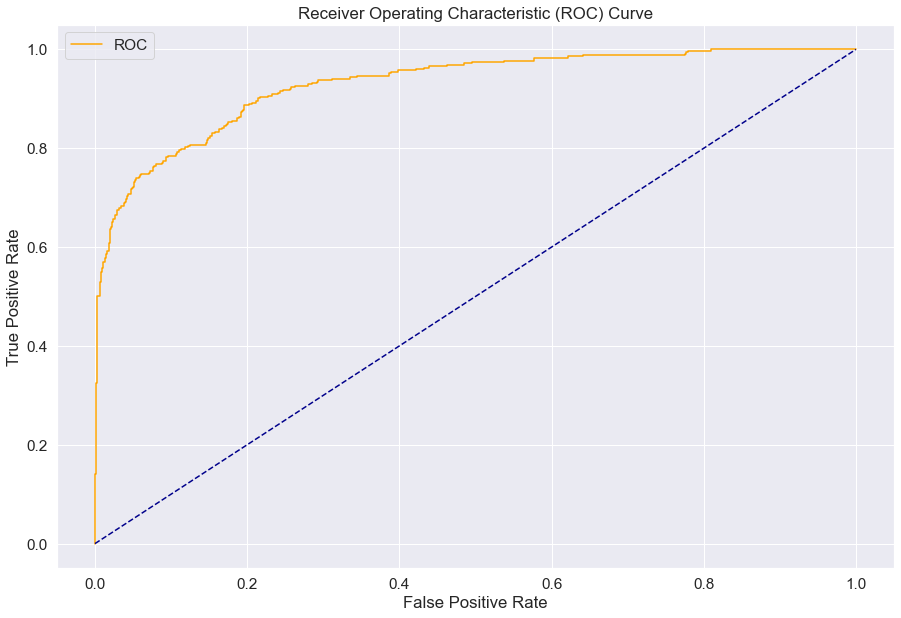

In [124]:
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(target_test, predict_proba_lgbm[:, 1])
plot_roc_curve(fpr_lgbm, tpr_lgbm)

<AxesSubplot:>

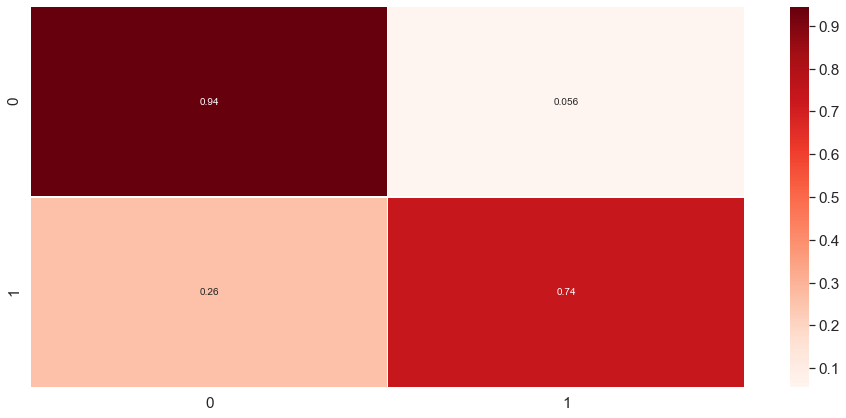

In [125]:
matrix = confusion_matrix(target_test, pred_lgbm)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize=(16, 7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Reds, linewidths=0.2)

Моделька вполне неплохо предсказывает - 0 (клиентов которые не ушли), верно предсказывает 94%  
1 (клиентов которые ушли) предсказывает похуже 74%

In [126]:
final = pd.DataFrame({'model' : ['randon forest', 'LGBM'],
                      'roc-auc' : [0.880, 0.929],
                      'accuracy' : [0.827, 0.891],
                      'precision' : [0.658, 0.823],
                      'recall' : [0.699, 0.739],
                      'f1' : [0.678, 0.779]})


<AxesSubplot:xlabel='model'>

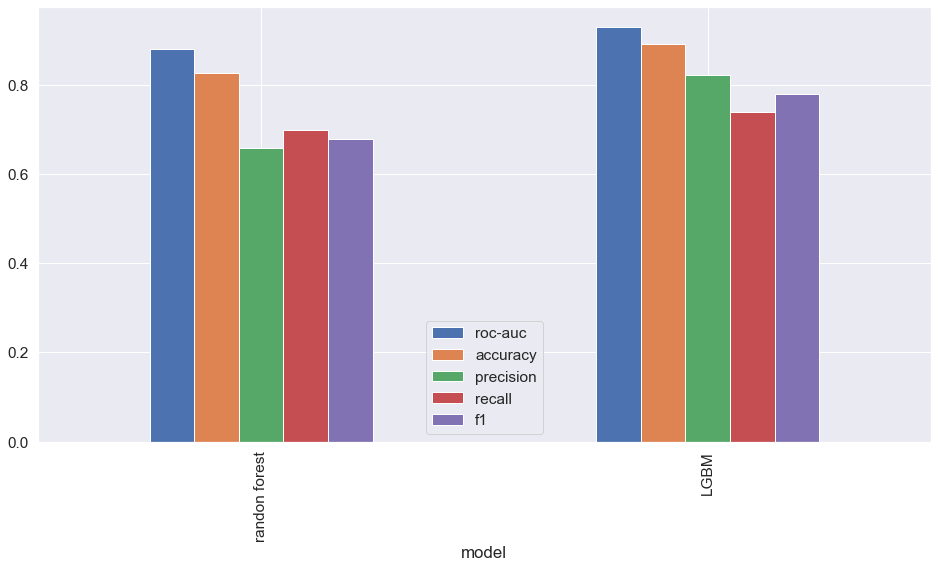

In [129]:
final.set_index('model').plot.bar(figsize=(16, 8))

In [130]:
final

,model,roc-auc,accuracy,precision,recall,f1
0,randon forest,0.880,0.827,0.658,0.699,0.678
1,LGBM,0.929,0.891,0.823,0.739,0.779


# Вывод

В ходе проекта было выполнено:  
1. Подготовка данных  
2. Исследование данных, поиск признаков влияющих на отток и удержание клиентов  
3. Сделан анализ выживаемости клиентов. Из него видно, когда стоит делать специальные предложения, чтобы не потерять пользователя.  
4. Протестированны две модели для прогноза оттока пользователей. RandomForest и LGBM. Обе модели достигли необходимого показателя метрики. LGBM оказался сильнее, быстро работает и показывает лучшую метрику roc-auc = 0.929